# HuggingFace Tutorial

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import joblib
import sys
import os
from huggingface_hub import HfFolder,notebook_login,HfApi,snapshot_download
from dotenv import load_dotenv
from matplotlib import pyplot as plt

C:\Users\Michael\AppData\Local\Temp\ipykernel_14888\705529812.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
pip install ipywidgets

  Obtaining dependency information for ipywidgets from https://files.pythonhosted.org/packages/4a/0e/57ed498fafbc60419a9332d872e929879ceba2d73cb11d284d7112472b3e/ipywidgets-8.1.1-py3-none-any.whl.metadata
  Using cached ipywidgets-8.1.1-py3-none-any.whl.metadata (2.4 kB)
  Obtaining dependency information for jupyterlab-widgets~=3.0.9 from https://files.pythonhosted.org/packages/e8/05/0ebab152288693b5ec7b339aab857362947031143b282853b4c2dd4b5b40/jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata
  Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl.metadata (4.1 kB)
Using cached ipywidgets-8.1.1-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl (214 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\Python311\\share'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Login into Huggingface and paste your API token below

If you have 401 authentication error, please invalidate and refresh your token. This can be done by going to your user api account settings and click manage token. If you still have problems reload the notebook_login without saving to environment variables and try again. (cell 3)

In [3]:
notebook_login()

ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Assuming the current directory is 'models', get the path of the 'TAQ-Query-Scripts' directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

token = os.getenv("hf_token")
user_token= os.getenv("hf_user_token")

# Use the token to authenticate
HfFolder.save_token(token)

### OLS Model - scikit-learn

                            OLS Regression Results                            
Dep. Variable:            Trade_Price   R-squared:                      -5.217
Model:                            OLS   Adj. R-squared:                 -5.232
Method:                 Least Squares   F-statistic:                    -333.6
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               1.00
Time:                        18:34:05   Log-Likelihood:                 21923.
No. Observations:                 798   AIC:                        -4.384e+04
Df Residuals:                     795   BIC:                        -4.383e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          294.6500   5.75e-12   5.13e+13   

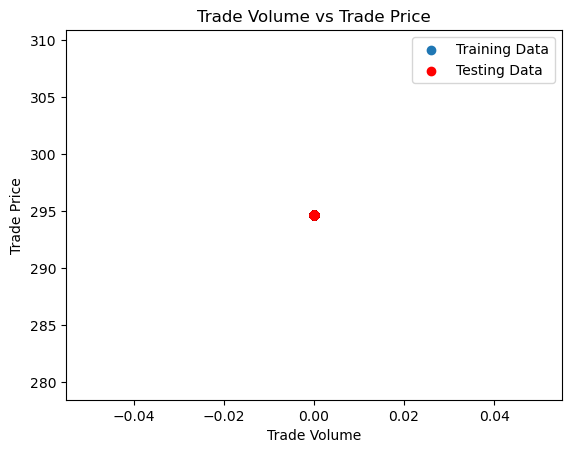

In [35]:
# Load the dataset
df_test = pd.read_csv('../sample_data/sample_features.csv')
df_test['Trade_Price'] = df_test['Trade_Price'].fillna(df_test['Trade_Price'].median())

# Selecting features for the model (adjust as necessary)
features = ['Trade_Volume', 'Bid_Price', 'Offer_Price']  # Example features
target = 'Trade_Price'

# Drop rows with missing target or features
df_test = df_test.dropna(subset=[target] + features)

# Check if the DataFrame is empty
if df_test.empty:
    print("No data available after removing missing values.")
else:
    # Define X (features) and y (target)
    X = df_test[features]
    y = df_test[target]

    # Adding a constant to the model (important for OLS regression)
    X = sm.add_constant(X)

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create the OLS model
    model = sm.OLS(y_train, X_train).fit()

    # Print model summary
    print(model.summary())

    # Save the model to a file
    model_filename = 'ols_model/ols_model.pkl'
    joblib.dump(model, model_filename)

    print(f"Model saved as {model_filename}")

    # Visualization plot
plt.scatter(X_train['Trade_Volume'], y_train, label='Training Data')
plt.scatter(X_test['Trade_Volume'], y_test, color='red', label='Testing Data')
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Trade Volume vs Trade Price')
plt.legend()
plt.savefig("ols_model/plot.png")
plt.show()

#### OLS Model - pytorch

Epoch [10/100], Loss: inf
Epoch [20/100], Loss: nan
Epoch [30/100], Loss: nan
Epoch [40/100], Loss: nan
Epoch [50/100], Loss: nan
Epoch [60/100], Loss: nan
Epoch [70/100], Loss: nan
Epoch [80/100], Loss: nan
Epoch [90/100], Loss: nan
Epoch [100/100], Loss: nan


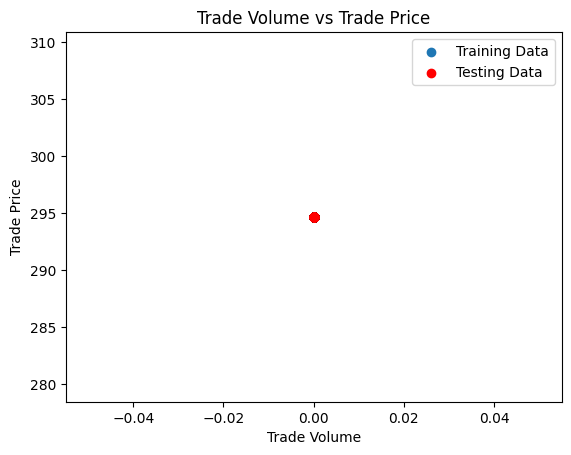

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
df_test = pd.read_csv('../sample_data/sample_features.csv')
df_test['Trade_Price'] = df_test['Trade_Price'].fillna(df_test['Trade_Price'].median())

# Selecting features for the model
features = ['Trade_Volume', 'Bid_Price', 'Offer_Price']  # Example features
target = 'Trade_Price'

# Drop rows with missing target or features
df_test = df_test.dropna(subset=[target] + features)

# Check if the DataFrame is empty
if df_test.empty:
    print("No data available after removing missing values.")
    exit()

# Define X (features) and y (target)
X = df_test[features]
y = df_test[target]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert DataFrame to Tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32).reshape(-1, 1))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32).reshape(-1, 1))

# PyTorch Model Definition
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize the model
input_size = X_train_tensor.shape[1]
model = LinearRegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Visualization plot
plt.scatter(X_train['Trade_Volume'], y_train, label='Training Data')
plt.scatter(X_test['Trade_Volume'], y_test, color='red', label='Testing Data')
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Trade Volume vs Trade Price')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'ols_model/pytorch_linear_regression_model.pth')


### Push Model to HuggingFace

For write access you will need to use a user-access token. You can create one by going to your profile settings and clicking on "New token". Make sure to copy the token after creating it, as you won't be able to access it afterwards.

In [5]:
# push the model to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/ols_model.pkl",
    path_in_repo="ols_model/ols_model.pkl",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)


NameError: name 'HfApi' is not defined

In [13]:
# Model file path
model_file_path = "pytorch_linear_regression_model.pth"

# Push the model to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj=model_file_path,
    path_in_repo="ols_model/pytorch_linear_regression_model.pth",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)

pytorch_linear_regression_model.pth:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/taqdatabase/OLS/commit/3467d3ca360ee1541db5a40edc2c2e7d17420883', commit_message='Upload ols_model/pytorch_linear_regression_model.pth with huggingface_hub', commit_description='', oid='3467d3ca360ee1541db5a40edc2c2e7d17420883', pr_url=None, pr_revision=None, pr_num=None)

In [36]:
# push the plot to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/plot.png",
    path_in_repo="ols_model/plots/plot.png",   # Change this to the desired path in the repo
    repo_id="taqdatabase/OLS",      # Change "username/repo_name" to your Hugging Face Hub repo
    repo_type="model"                # Use "model" or "dataset" depending on the repository type
)

CommitInfo(commit_url='https://huggingface.co/taqdatabase/OLS/commit/74fc026dc80099a4114fa785160749fd999323c5', commit_message='Upload ols_model/plots/plot.png with huggingface_hub', commit_description='', oid='74fc026dc80099a4114fa785160749fd999323c5', pr_url=None, pr_revision=None, pr_num=None)

### Push CSV to HuggingFace

In [4]:
pd.DataFrame(model.summary().tables[0]).to_csv('ols_model/ols_model_summary.csv')

AttributeError: 'LinearRegressionModel' object has no attribute 'summary'

### Save CSV to HuggingFace

In [32]:
# push the model to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/ols_model_summary.csv",
    path_in_repo="ols_model/ols_model_summary.csv",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)

CommitInfo(commit_url='https://huggingface.co/taqdatabase/OLS/commit/33918da840f84cb602bbb5b42f74192502ba5119', commit_message='Upload ols_model/ols_model_summary.csv with huggingface_hub', commit_description='', oid='33918da840f84cb602bbb5b42f74192502ba5119', pr_url=None, pr_revision=None, pr_num=None)


### Load Model from HuggingFace Hub

In [28]:
snapshot_download(repo_id="taqdatabase/OLS")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]
.gitattributes: 100%|██████████| 1.52k/1.52k [00:00<00:00, 891kB/s]
README.md: 100%|██████████| 97.0/97.0 [00:00<00:00, 3.10kB/s]
ols_model.pkl: 100%|██████████| 197k/197k [00:00<00:00, 2.82MB/s]
Fetching 3 files: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


'/home/jbohne/.cache/huggingface/hub/models--taqdatabase--OLS/snapshots/3ccc806307a32f9787b088a3c8001407798ebf06'

# To do
1. add parameter estimate
2. chart with intervals/estimate and p-values